<a href="https://colab.research.google.com/github/atharvakale31/DL_auto_encoders/blob/master/CVAE_on_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [ ]:
%tensorflow_version 1.x 

TensorFlow 1.x selected.


In [ ]:
dataset_url = "http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz"
data_dir = tf.keras.utils.get_file('images', origin=dataset_url,  cache_dir='.', untar=True)

541564928/541562880 [==============================] - 29s 0us/step


In [ ]:
!cp -r "/content/drive/MyDrive/augmented_images" "/content/"

In [ ]:
img_list = sorted(glob.glob('/content/datasets/images/*/*.png'))

In [ ]:
len(img_list)

4947

In [ ]:
IMG_SIZE = 32
IMG_HEIGHT=32
IMG_WIDTH = 32
img_data_array=[]
# x_data = np.empty((len(img_list), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
for i, img_path in enumerate(img_list):

  image= cv2.imread( img_path)
  image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
  image=np.array(image)
  image = image.astype('float32')
  # image /= 255 
  img_data_array.append(image)
 
  

# ## read and convert to arrays
# for i, img_path in enumerate(img_list):
#     # read image
#     img = imread(img_path)
#     # resize image (1 channel used for example; 1 for gray-scale, 3 for RGB-scale)
#     img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 3), preserve_range=True)
#     # save to numpy array
#     x_data[i] = img

In [ ]:
img_data=np.array(img_data_array, np.float32)

In [ ]:
len(img_list)

4947

In [ ]:
len(img_data)

4947

In [ ]:
del img_data_array

In [ ]:
train_images, test_images,_, _ = train_test_split(img_data, img_data, test_size=0.01, random_state=42)

In [ ]:
train_images=train_images.reshape((train_images.shape[0],train_images.shape[1], train_images.shape[2], 3))
test_images=test_images.reshape((test_images.shape[0],test_images.shape[1], test_images.shape[2], 3))

In [ ]:
print(train_images.shape)
print(test_images.shape)

(4897, 32, 32, 3)
(50, 32, 32, 3)


In [ ]:
del img_data

In [ ]:
"""
  Convolutional structure for the encoder net
"""

encoder = tf.keras.Sequential([
    layers.Conv2D(filters=64 , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2D(filters=128, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2D(filters=512, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Flatten()
])

"""
  DeConv structure for the decoder net
"""

decoder = tf.keras.Sequential([
    layers.Dense(2048),
    layers.Reshape(target_shape=(4, 4, 128), input_shape=(None, 1024)),
    layers.Conv2DTranspose(filters=256, kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2DTranspose(filters=64 , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same'),
    layers.Conv2DTranspose(filters=3  , kernel_size=4, strides=2, activation=tf.nn.relu, padding='same')
])

In [ ]:
encoder.summary()

ValueError: ignored

In [ ]:
decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             multiple                  2099200   
_________________________________________________________________
reshape_2 (Reshape)          multiple                  0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr multiple                  524544    
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr multiple                  262208    
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr multiple                  3075      
Total params: 2,889,027
Trainable params: 2,889,027
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 32

x = tf.placeholder(tf.float32, shape=[batch_size,32, 32, 3])

encoded = encoder(x)

mean = layers.Dense(1024, tf.nn.softplus)(encoded)
sigma = layers.Dense(1024, tf.nn.relu)(encoded)

z = mean + tf.multiply(tf.sqrt(tf.exp(sigma)),
                       tf.random.normal(shape=(batch_size, 1024)))

x_reco = decoder(z)

In [ ]:
reconstruction_term = -tf.reduce_sum(tfp.distributions.MultivariateNormalDiag(layers.Flatten()(x_reco),
                                        scale_identity_multiplier=0.05).log_prob(layers.Flatten()(x)))

kl_divergence = tf.reduce_sum(tf.keras.metrics.kullback_leibler_divergence(x, x_reco), axis=[1, 2])

cost = tf.reduce_mean(reconstruction_term + kl_divergence)

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

In [ ]:
from tensorflow.keras.datasets.cifar10 import load_data
(X_train, y_train), (X_test, y_test) = load_data()


  9445376/170498071 [>.............................] - ETA: 10s

KeyboardInterrupt: ignored

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
runs = 200
n_minibatches = int(train_images.shape[0] / batch_size)

print("Number of minibatches: ", n_minibatches)

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(runs):
    pbar = tf.contrib.keras.utils.Progbar(n_minibatches)
    for i in range(n_minibatches):
        
        x_batch = train_images[i*batch_size:(i+1)*batch_size]/255.
        cost_, _ = sess.run((cost, optimizer), feed_dict={x: x_batch})

        pbar.add(1,[("cost",cost_)])

Number of minibatches:  153


/tensorflow-1.15.2/python3.7/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


153/153 [==============================] - 2s 12ms/step - cost: -110924.8263


Input 32x32x3

100 runs batch size 16 cost  -20k

200 runs batch size 32 cost -110924.8263

100 runs batch size 64 cost  -119960.1608

200 runs batch size 64 cost  -183667.2434

100 runs batch size 100 cost -88718.3007

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


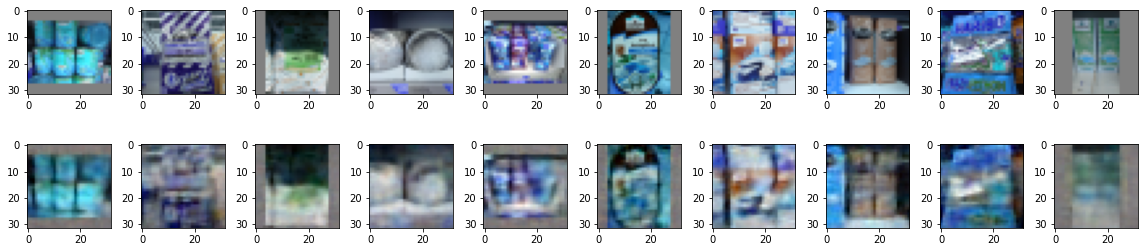

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n_rec = 10

x_batch = train_images[0:batch_size]

plt.figure(figsize=(n_rec+6,4))

pred_img = sess.run(x_reco, feed_dict={x: x_batch})
pred_img = pred_img.reshape(batch_size, 32, 32, 3)
pred_img = pred_img.astype(np.int32)

for i in range(n_rec):
    
    plt.subplot(2, n_rec, i+1)
    plt.imshow(x_batch[i]/255.)

    plt.subplot(2, n_rec, n_rec+i+1)
    plt.imshow(pred_img[i])

plt.tight_layout()